# Roll decay test parameter sensitivity

None of the methods worked well unless the initial large roll angles were removed, probably beacause the nonlinearities are higher than quadratic for this case. Removing these angles (making the model valid for only smaller angles) is one option. Another option is to allow higher order damping terms in the simulation model for the fitting (the higher order terms can later be transfered to a model with linear och quadratic order at a later stage if required). How the cutting affects the parameter identification should be further investigated.

A sensitivity stuffy regarding the impact of lowpass filtering on the parameter identification should also be conducted. 


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

import os
from scipy.optimize import curve_fit

from rolldecay.simulation import  simulate
#import rolldecay.parameter_identification as parameter_identification
import rolldecay.read_funky_ascii
import inspect
from rolldecayestimators.direct_estimator import DirectEstimator,NorwegianEstimator
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer
from rolldecay.equations_lambdify import calculate_acceleration, calculate_velocity
from sklearn.pipeline import Pipeline


## Roll decay model test

In [3]:
ascii_path = os.path.join(rolldecay.data_path,'project1','Ascii files','20084871056k.15.asc')
df_raw = rolldecay.read_funky_ascii.read(ascii_path=ascii_path)[['phi']]

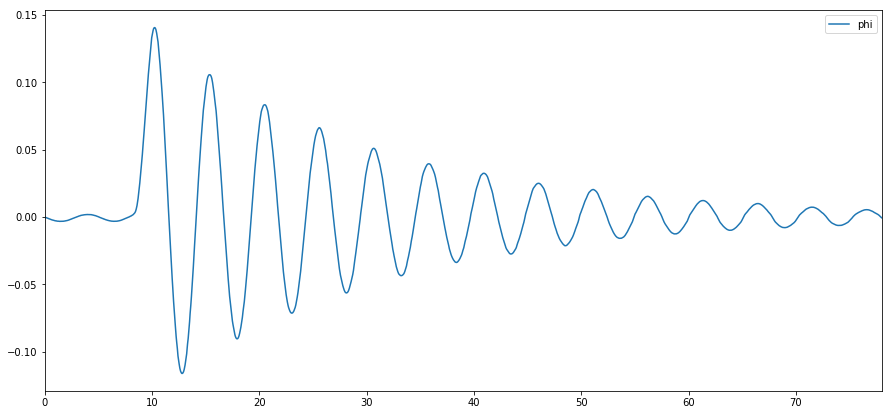

In [4]:
df_raw.plot(y='phi')

In [5]:
N=100
cutoffs = np.linspace(0.3,1,N)
scores = []
for cutoff in cutoffs:
    lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=cutoff)
    lowpass_filter.fit(X=df_raw)
    score = lowpass_filter.score(X=df_raw)
    scores.append(score)
    

Text(0, 0.5, 'score')

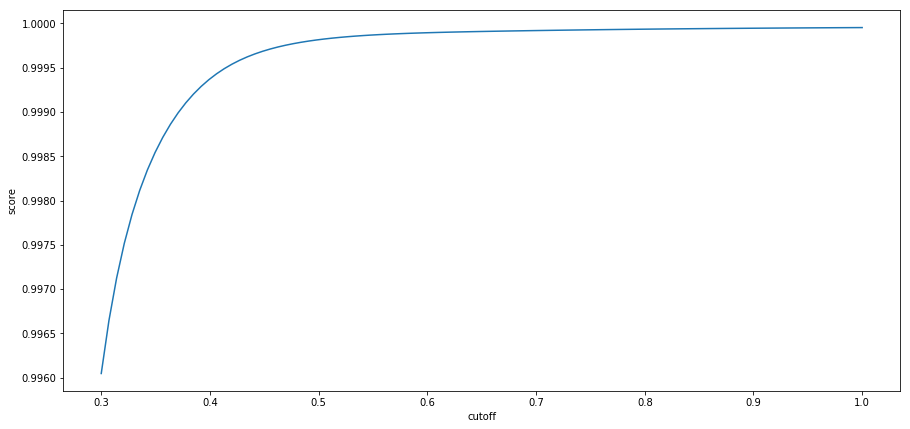

In [6]:
fig,ax = plt.subplots()
ax.plot(cutoffs, scores)
ax.set_xlabel('cutoff')
ax.set_ylabel('score')

In [7]:
lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=1)
lowpass_filter.fit(X=df_raw)

df = lowpass_filter.transform(X=df_raw)

scaler = ScaleFactorTransformer(scale_factor=29.565)
scaler.fit(X=df)
df = scaler.transform(X=df)
df_raw_full_scale = scaler.transform(X=df_raw)


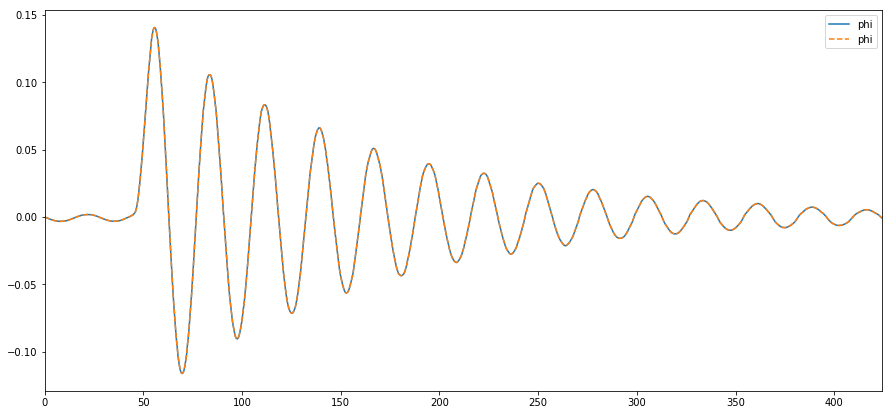

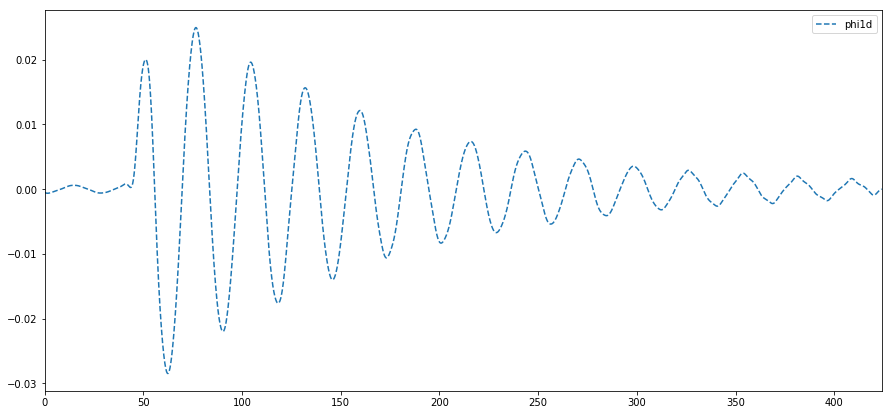

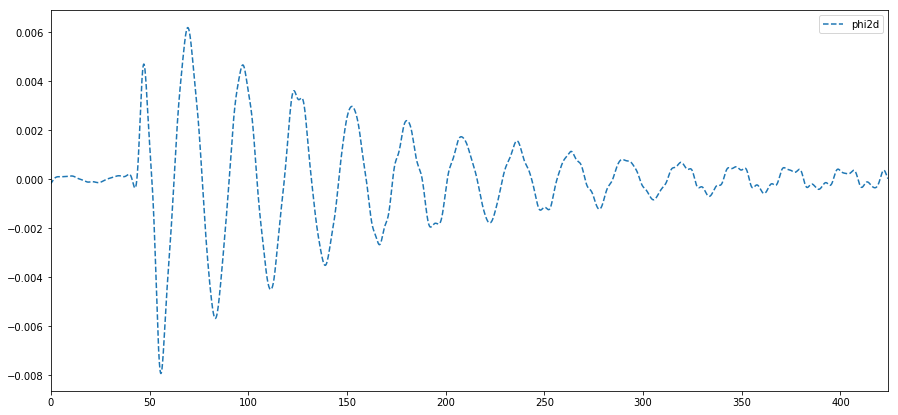

In [54]:
fig,ax=plt.subplots()
df_raw_full_scale.plot(y='phi', ax=ax)
df.plot(y='phi', ax=ax, style='--')
ax.legend();

fig,ax=plt.subplots()
df.plot(y='phi1d', ax=ax, style='--')
ax.legend();

fig,ax=plt.subplots()
df.plot(y='phi2d', ax=ax, style='--')
ax.legend();

### Cutting the file at max value 

In [9]:
cutter = CutTransformer(phi_max=np.deg2rad(5), phi_min=np.deg2rad(0.5))
cutter.fit(X=df_raw)
df_cut = cutter.transform(X=df_raw)

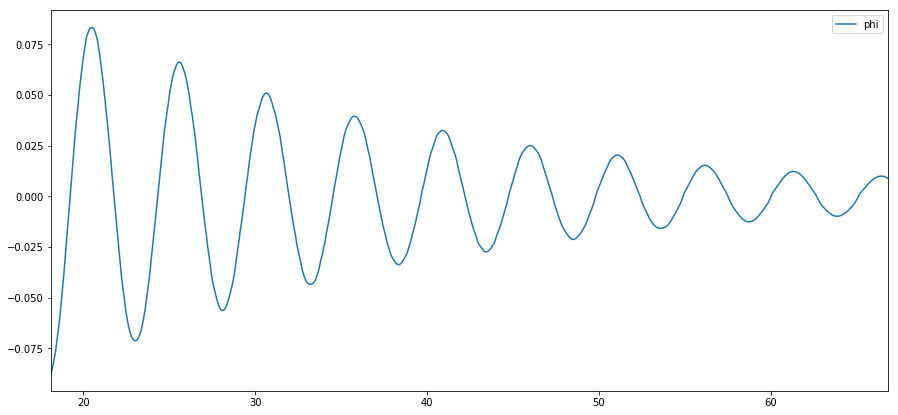

In [10]:
df_cut.plot(y='phi')

In [11]:
lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=1.0)
scaler = ScaleFactorTransformer(scale_factor=29.565)
cutter = CutTransformer(phi_max=np.deg2rad(8), phi_min=np.deg2rad(0.05))
direct_estimator = DirectEstimator(calculate_acceleration=calculate_acceleration, simulate=simulate)

steps = [
    ('filter',lowpass_filter),
    ('scaler',scaler),
    ('cutter', cutter), 
    ('direct_estimator', direct_estimator)]
pipeline = Pipeline(steps) # define the pipeline object.

In [12]:
pipeline.fit(X=df_raw)

Pipeline(memory=None,
         steps=[('filter',
                 LowpassFilterDerivatorTransformer(cutoff=1.0, order=5)),
                ('scaler', ScaleFactorTransformer(scale_factor=29.565)),
                ('cutter',
                 CutTransformer(phi_max=0.13962634015954636,
                                phi_min=0.0008726646259971648)),
                ('direct_estimator',
                 DirectEstimator(calculate_acceleration=<function _lambdifygenerated at 0x0E277E40>,
                                 p0=[0.01, 0.22, 0.01],
                                 simulate=<function simulate at 0x0EF9E858>))],
         verbose=False)

In [13]:
pipeline.score(X=df_raw)

0.9990665811162585

In [14]:
df_sim_direct = pipeline.predict(X=df_raw)

In [15]:
pipeline['cutter']

CutTransformer(phi_max=0.13962634015954636, phi_min=0.0008726646259971648)

In [18]:
direct_estimator.parameters

{'d': 4.351854814690697e-05,
 'omega0': 0.2263628127271239,
 'zeta': 0.03768035217933889}

In [191]:
lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=1)
scaler = ScaleFactorTransformer(scale_factor=29.565)
cutter = CutTransformer(phi_max=np.deg2rad(8), phi_min=np.deg2rad(0.05))
norwegian_estimator = NorwegianEstimator(calculate_acceleration=calculate_acceleration, simulate=simulate)

steps = [
    ('filter',lowpass_filter),
    ('scaler',scaler),
    ('cutter', cutter), 
    ('norwegian_estimator', norwegian_estimator)]
pipeline2 = Pipeline(steps) # define the pipeline object.

In [192]:
pipeline2.fit(X=df_raw)

Pipeline(memory=None,
         steps=[('filter',
                 LowpassFilterDerivatorTransformer(cutoff=1, order=5)),
                ('scaler', ScaleFactorTransformer(scale_factor=29.565)),
                ('cutter',
                 CutTransformer(phi_max=0.13962634015954636,
                                phi_min=0.0008726646259971648)),
                ('norwegian_estimator',
                 NorwegianEstimator(calculate_acceleration=<function _lambdifygenerated at 0x0E277E40>,
                                    simulate=<function simulate at 0x0EF9E858>))],
         verbose=False)

In [193]:
pipeline2.score(X=df_raw)

0.9991045463861425

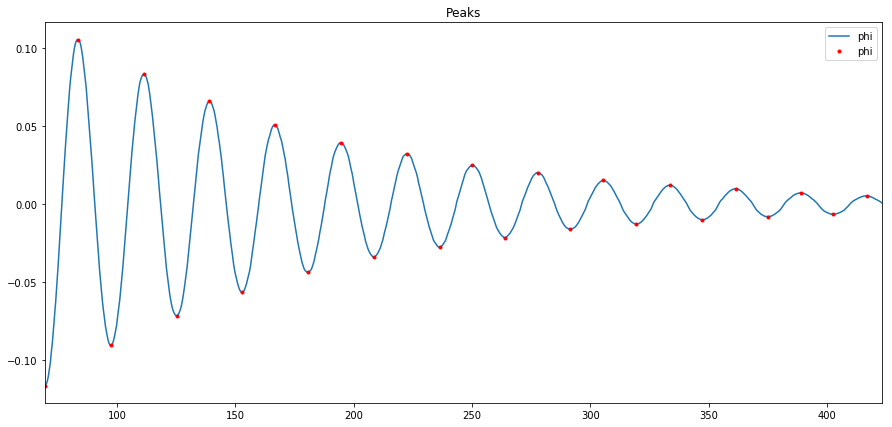

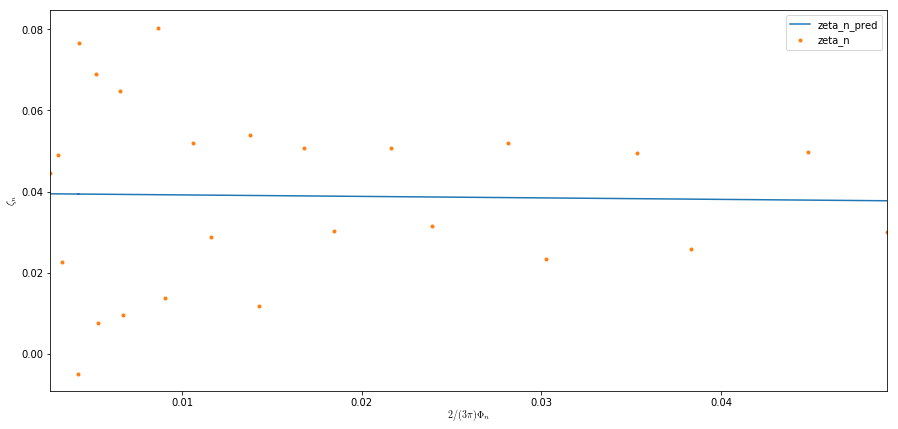

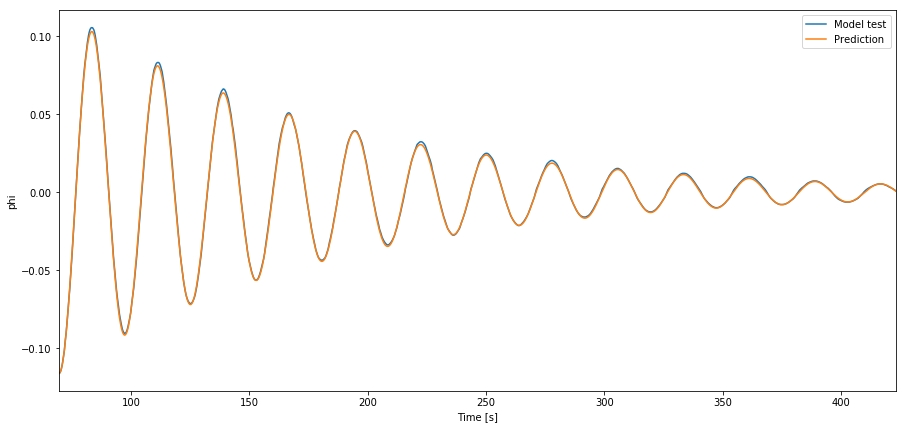

In [194]:
estimator = pipeline2['norwegian_estimator']
estimator.plot_peaks()
estimator.plot_damping()
estimator.plot_fit()

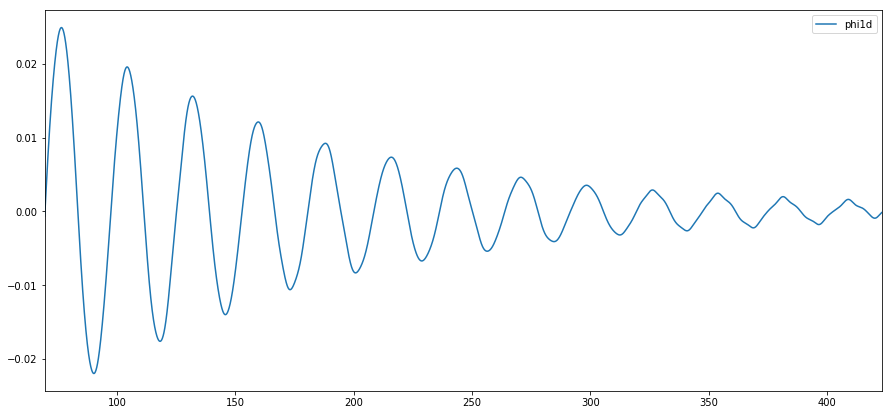

In [195]:
estimator.X.plot(y='phi1d')

In [196]:
df_sim_norwegian = pipeline2.predict(X=df_raw)

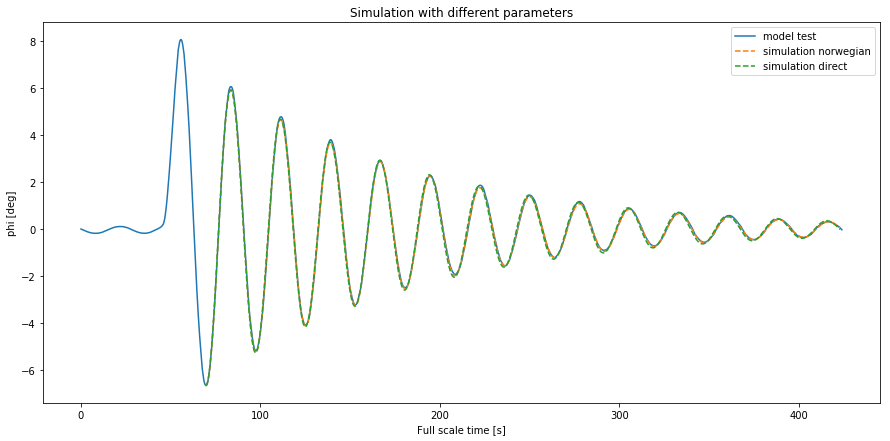

In [197]:
fig,ax = plt.subplots()

from collections import OrderedDict
dfs = OrderedDict()
dfs['model test']={'df':df_raw_full_scale,'style':'-', 'alpha':1}
#dfs['simulation report']={'df':df_sim_report}
dfs['simulation norwegian']={'df':df_sim_norwegian}
dfs['simulation direct']={'df':df_sim_direct}

for label,data in dfs.items():
    df_ = data['df']
    style = data.get('style','--')
    alpha = data.get('alpha',1)
    ax.plot(df_.index,np.rad2deg(df_['phi']),style, label=label, alpha=alpha)

ax.legend()
ax.set_xlabel('Full scale time [s]')
ax.set_ylabel('phi [deg]')
ax.set_title('Simulation with different parameters');

## Optimize pipline

### Optimize filter

In [209]:
scaler = ScaleFactorTransformer(scale_factor=29.565).fit(X=df_raw)
cutter = CutTransformer(phi_max=np.deg2rad(7), phi_min=np.deg2rad(0.05)).fit(X=df_raw)
direct_estimator = DirectEstimator(calculate_acceleration=calculate_acceleration, simulate=simulate)
norwegian_estimator = NorwegianEstimator(calculate_acceleration=calculate_acceleration, simulate=simulate)

N=300
cutoffs = np.linspace(0.5,5,N)
df_cuttoffs = pd.DataFrame()
df_cuttoffs_norwegian = pd.DataFrame()

for cutoff in cutoffs:
    
    lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=cutoff, order=1)
    lowpass_filter.fit(X=df_raw)   
    
    steps = [
        ('filter',lowpass_filter),
        ('scaler',scaler),
        ('cutter', cutter), 
        ('direct_estimator', direct_estimator)]
    pipeline = Pipeline(steps) # define the pipeline object.
    pipeline.fit(X=df_raw)

    s = pd.Series(pipeline['direct_estimator'].parameters)
    s['mean_damping'] = pipeline['direct_estimator'].calculate_average_linear_damping(phi_a=np.deg2rad(4))
    s['score'] = pipeline.score(X=df_raw)
    s['cutoff'] = cutoff
    df_cuttoffs = df_cuttoffs.append(s, ignore_index=True)
    
    lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=cutoff, order=1)
    lowpass_filter.fit(X=df_raw)   
    steps = [
        ('filter',lowpass_filter),
        ('scaler',scaler),
        ('cutter', cutter), 
        ('norwegian_estimator', norwegian_estimator)]
    pipeline2 = Pipeline(steps) # define the pipeline object.
    pipeline2.fit(X=df_raw)

    s = pd.Series(pipeline2['norwegian_estimator'].parameters)
    s['mean_damping'] = pipeline2['norwegian_estimator'].calculate_average_linear_damping(phi_a=np.deg2rad(4))
    s['score'] = pipeline2.score(X=df_raw)
    s['cutoff'] = cutoff
    df_cuttoffs_norwegian = df_cuttoffs_norwegian.append(s, ignore_index=True)
    


Text(0, 0.5, 'score')

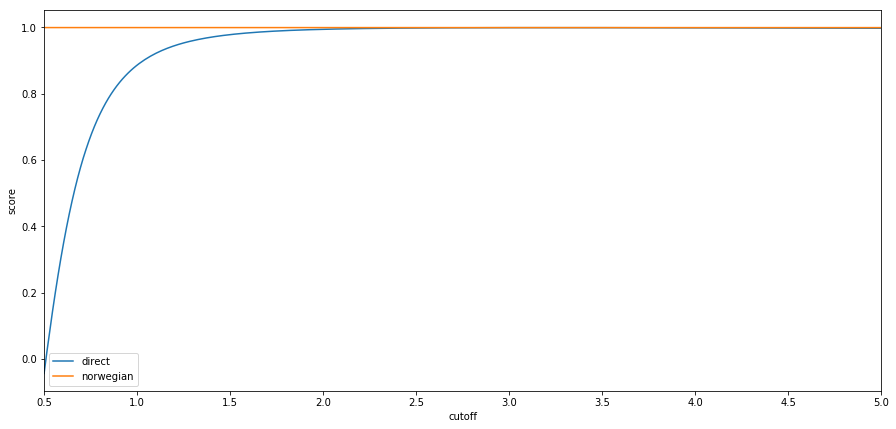

In [210]:
fig,ax = plt.subplots()
df_cuttoffs.plot(x='cutoff', y='score', ax=ax, label='direct')
df_cuttoffs_norwegian.plot(x='cutoff', y='score', ax=ax, label='norwegian')
ax.set_ylabel('score')

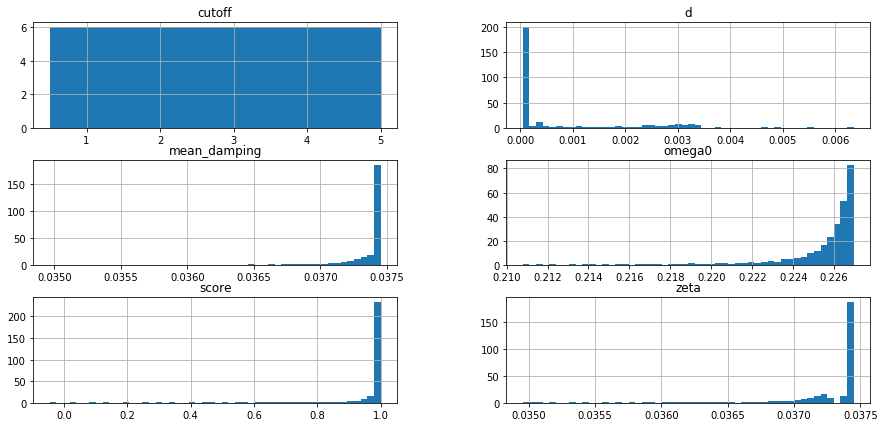

In [211]:
df_cuttoffs.hist(bins=50);

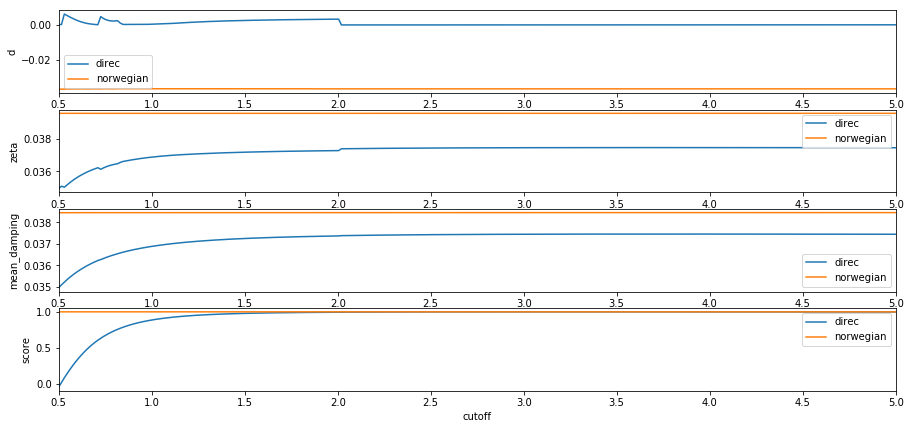

In [212]:
fig,axes = plt.subplots(nrows=4)

ys = ['d','zeta','mean_damping','score']

for ax,y in zip(axes,ys):
    df_cuttoffs.plot(x='cutoff', y=y, ax=ax, label='direc')
    df_cuttoffs_norwegian.plot(x='cutoff', y=y, ax=ax, label='norwegian')
    ax.legend()
    ax.set_ylabel(y)




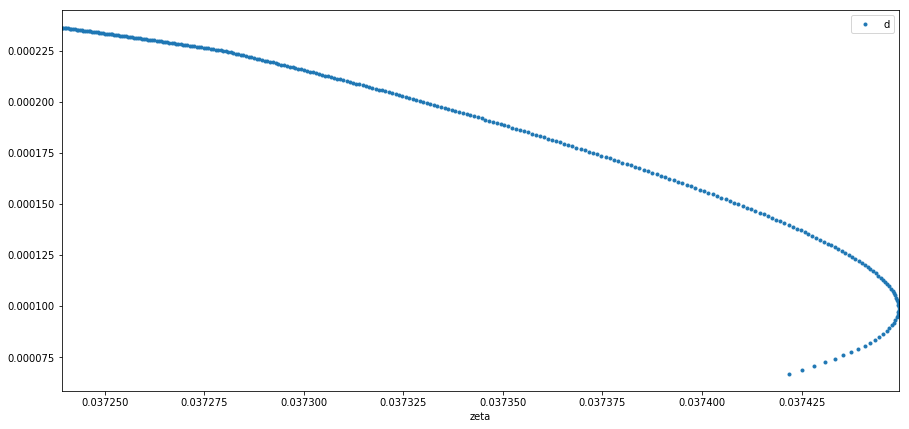

In [43]:
fig,ax = plt.subplots()
df_cuttoffs.plot(x='zeta', y='d', ax=ax, style='.')

In [44]:
lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=6, order=1)
lowpass_filter.fit(X=df_raw)   

steps = [
    ('filter',lowpass_filter),
    ('scaler',scaler),
    ('cutter', cutter), 
    ('direct_estimator', direct_estimator)]
pipeline = Pipeline(steps) # define the pipeline object.

pipeline.fit(X=df_raw)
pipeline.score(X=df_raw)
df_sim_direct = pipeline.predict(X=df_raw)

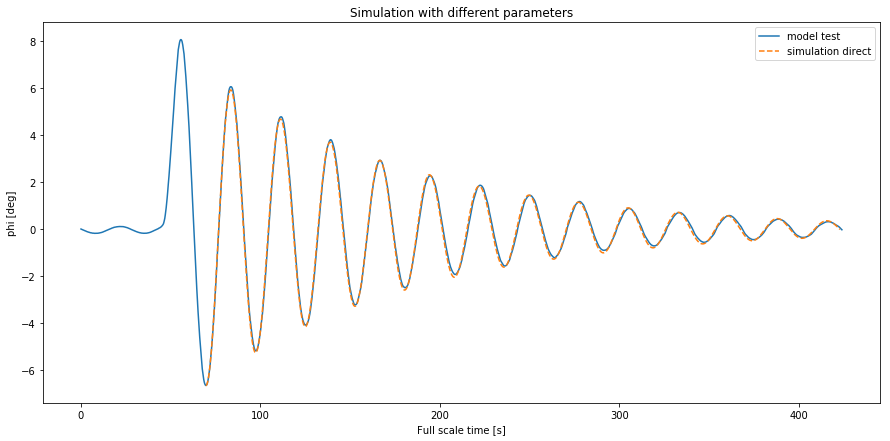

In [45]:
fig,ax = plt.subplots()

from collections import OrderedDict
dfs = OrderedDict()
dfs['model test']={'df':df_raw_full_scale,'style':'-', 'alpha':1}
dfs['simulation direct']={'df':df_sim_direct}

for label,data in dfs.items():
    df_ = data['df']
    style = data.get('style','--')
    alpha = data.get('alpha',1)
    ax.plot(df_.index,np.rad2deg(df_['phi']),style, label=label, alpha=alpha)

ax.legend()
ax.set_xlabel('Full scale time [s]')
ax.set_ylabel('phi [deg]')
ax.set_title('Simulation with different parameters');

### Optimize cutting

In [46]:
lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=5, order=1)
lowpass_filter.fit(X=df_raw) 
scaler = ScaleFactorTransformer(scale_factor=29.565).fit(X=df_raw)
direct_estimator = DirectEstimator(calculate_acceleration=calculate_acceleration, simulate=simulate)

N=500
phi_starts = np.linspace(2,6,N)
df_starts = pd.DataFrame()

for phi_start in phi_starts:
    
    cutter = CutTransformer(phi_max=np.deg2rad(phi_start), phi_min=np.deg2rad(0.05)).fit(X=df_raw)
        
    steps = [
        ('filter',lowpass_filter),
        ('scaler',scaler),
        ('cutter', cutter), 
        ('direct_estimator', direct_estimator)]
    pipeline = Pipeline(steps) # define the pipeline object.
    
    pipeline.fit(X=df_raw)
    s = pd.Series(pipeline['direct_estimator'].parameters)
    s['mean_damping'] = pipeline['direct_estimator'].calculate_average_linear_damping(phi_a=np.deg2rad(4))
    s['score'] = pipeline.score(X=df_raw)
    s['phi_start'] = phi_start
    df_starts = df_starts.append(s, ignore_index=True)
    
    

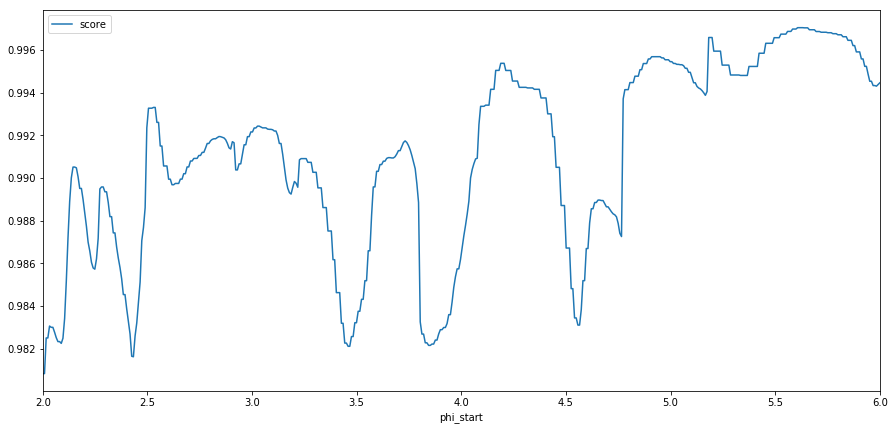

In [47]:
fig,ax = plt.subplots()
df_starts.plot(x='phi_start', y='score', ax=ax)


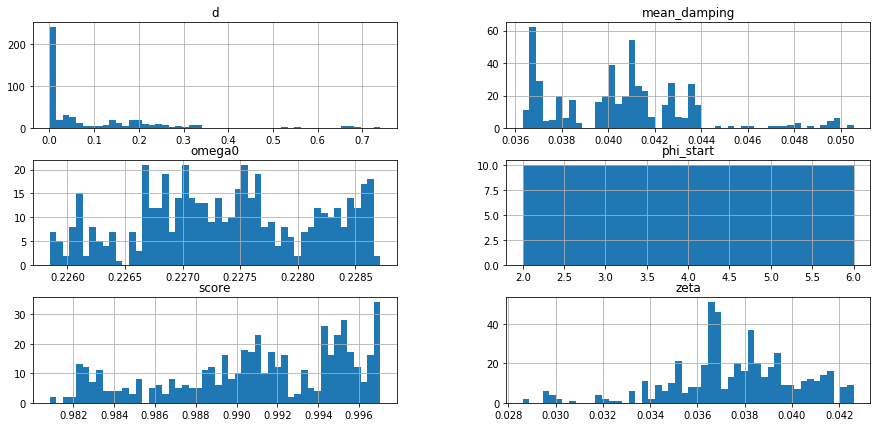

In [48]:
df_starts.hist(bins=50);

In [49]:
mask = df_starts['score'] > 0.99
df_starts_best = df_starts.loc[mask].copy()

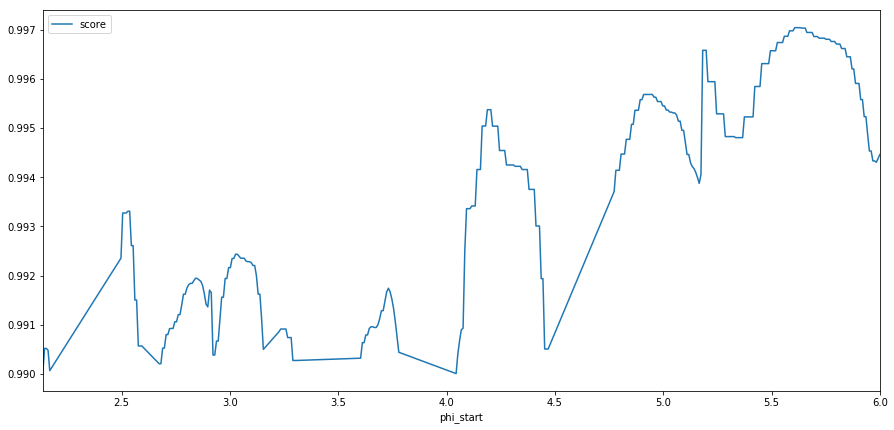

In [50]:
fig,ax = plt.subplots()
df_starts_best.plot(x='phi_start', y='score', ax=ax)

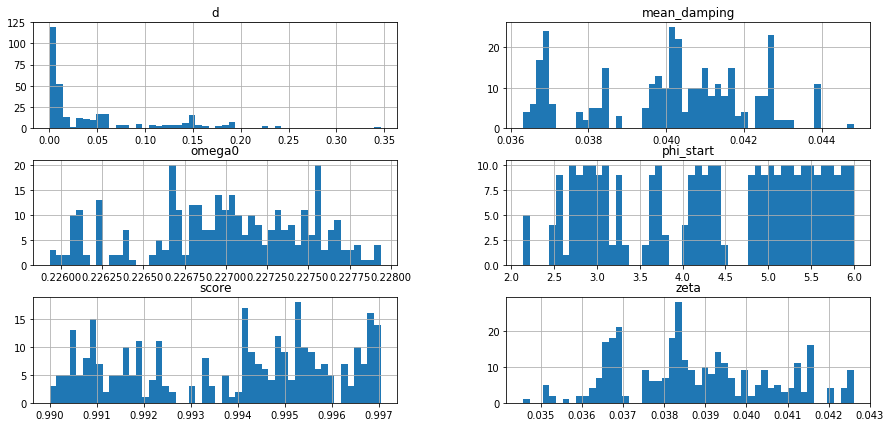

In [51]:
df_starts_best.hist(bins=50);

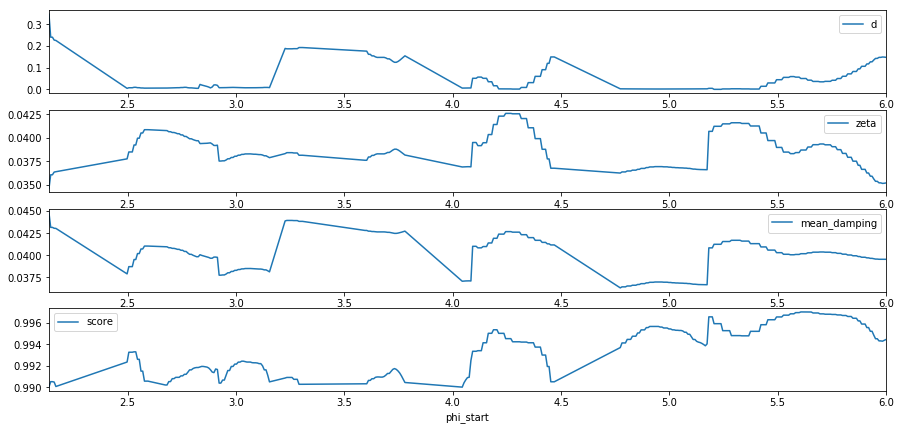

In [52]:
fig,axes = plt.subplots(nrows=4)
ax=axes[0]
df_starts_best.plot(x='phi_start', y='d', ax=ax)

ax=axes[1]
df_starts_best.plot(x='phi_start', y='zeta', ax=ax)

ax=axes[2]
df_starts_best.plot(x='phi_start', y='mean_damping', ax=ax)

ax=axes[3]
df_starts_best.plot(x='phi_start', y='score', ax=ax)


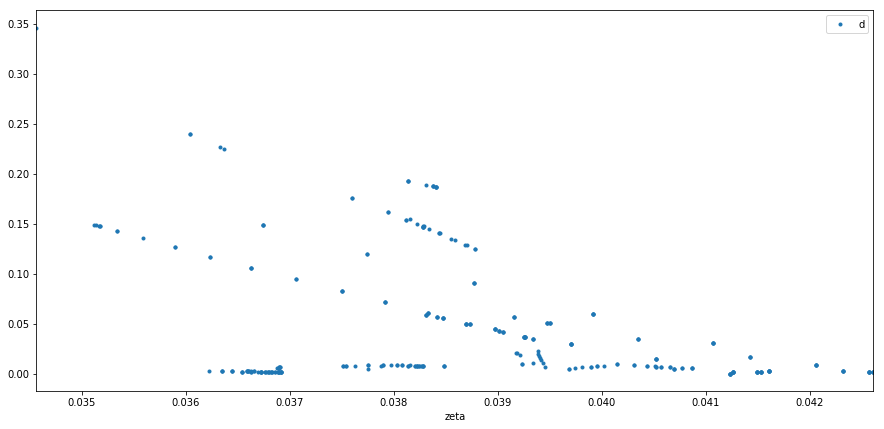

In [53]:
fig,ax = plt.subplots()
df_starts_best.plot(x='zeta', y='d', ax=ax, style='.')

